In [1]:
# Importing Libraries
import tables
import matplotlib.pyplot as plt
import numpy as np
import sys
# sys.path.append('/Users/eframe/dmi/src')
# import compton 
# import codedAperture as ca
# import eventAnalysis as ea
# import calibrate as calib
import matplotlib.ticker as ticker
import pandas as pd
from scipy.optimize import curve_fit
from matplotlib.font_manager import FontProperties

In [2]:
def lorentzian1(x, amp, cen, sig):
    return ( amp / np.pi ) * ( sig / ( ( x-cen ) **2 + sig**2 ) )

In [3]:
def convertToConeData_SIM(energy, pos, Es, leverThres):
    """Gets cone data from CCI-2 doubles events
    """

    E1 = energy[:, 0]
    E2 = energy[:, 1]

    coneMu = 1 + 511 * ( 1 / Es - 1 / E2 )
    
    coneMu[ ( coneMu < -1 ) | ( coneMu > 1 ) ] = -1

    # Get Interaction Position Order
    pos1 = pos[:,0]
    pos2 = pos[:,1]

    # Get Cone Direction
    coneAxes = pos2 - pos1

    norms = np.sqrt( ( coneAxes ** 2 ).sum( axis = 1 ) )
    coneDirs = coneAxes / norms[ :, np.newaxis ]

    # Lever Arm Threshold
    lmask = norms >= leverThres

    return pos1[lmask], pos2[lmask], coneDirs[lmask], coneMu[lmask]

In [4]:
# Defining new source image space for each pose
sourceX, sourceY, sourceZ = np.mgrid[ -29:31:2, -29:31:2, -29:31:2 ]
sourcePixels = np.array([sourceX.flatten(), sourceY.flatten(), sourceZ.flatten()]).T
B = np.array( [ [ 1, 0, 0 ], [ 0, 1, 0 ], [ 0, 0, 1 ] ] )
C = np.array([ 0, 0, 170])
ang = 0 
R = np.array( [  [ np.cos(ang), 0, np.sin(ang) ], [ 0, 1, 0 ], [ -np.sin(ang), 0, np.cos(ang) ] ] ).T
K = np.array( np.dot( R, B ) )
sourcePixelsNew =  np.dot( sourcePixels, K ) + C  

In [5]:
# Calculating Sensitivity Map 1
x = sourcePixelsNew[:,0]
y = sourcePixelsNew[:,1]
z = sourcePixelsNew[:,2]
c1 = x + 38
c2 = x - 38
d1 = y + 38
d2 = y - 38
a1 = c1 / np.sqrt( c1 ** 2 + z ** 2 )
b1 = d1 / np.sqrt( d1 ** 2 + z ** 2 )
a2 = c2 / np.sqrt( c2 ** 2 + z ** 2 )
b2 = d2 / np.sqrt( d2 ** 2 + z ** 2 )
firstsum = np.arcsin( a1 * b1 ) * ( ( -1 ) ** 2 ) + np.arcsin( a1 * b2 ) * ( ( -1 ) ** 3 )
secondsum = np.arcsin( a2 * b1 ) * ( ( -1 ) ** 3 ) + np.arcsin( a2 * b2 ) * ( ( -1 ) ** 4 )
sens =  ( firstsum + secondsum ) / ( 4 * np.pi ) * 0.012
sensMap = sens 

In [105]:
# Getting Compton cones from detector data 
E = 1410
sigma = 4
lever_thres=14
file = '/Users/eframe/Desktop/Eu152_z165.h5'
f = tables.open_file(file, 'r')

d = f.root.Interactions.Double.read()
d['x'] = d['x'] - 38
d['y'] = d['y'] - 38

l22 = d.reshape( int ( len ( d ) / 2 ), 2 )    

# Getting Cone Data
emask = ( l22['energy'].sum( axis = 1 ) >= E - sigma ) & ( l22['energy'].sum( axis = 1 ) <= E + sigma )   
events_old = l22[emask]
events = compton.correct_depth( events_old )
events['z'] = -events['z']

# # Sequencing Interactions
energy1 = np.array( [ events['energy' ][ :, 0 ], events['energy'][ :, 1 ] ] ).T
energy2 = np.array( [ events['energy' ][ :, 1 ], events['energy'][ :, 0 ] ] ).T
p1 = np.squeeze( np.array( [ events['x'][ :, 0 ], events['y'][ :, 0 ], events['z'][ :, 0 ] ] ) ).T
p2 = np.squeeze( np.array( [ events['x'][ :, 1 ], events['y'][ :, 1 ], events['z'][ :, 1 ] ] ) ).T
pos1 = np.concatenate( ( [ p1, p2 ] ) , axis = 1 ).reshape( len( p1 ), 2, 3 )
pos2 = np.concatenate( ( [ p2, p1 ] ) , axis = 1 ).reshape( len( p1 ), 2, 3 )

P12, P21 = compton.sequence_probability( energy1, pos1, E )
mask = ( P12 < P21 )
energy = energy1.copy()
energy[mask] = energy2[mask]
pos = pos1.copy()
pos[mask] = pos2[mask]
iP, iP2, cD, cM = compton.convertToConeData_SEQ( energy, pos, E, lever_thres )    

# # Computing Cone Data for Both Interaction Combinations
# iP, iP2, cD, cM = compton.convertToConeData( events, E, lever_thres )

# Applying Threshold to Eliminate Light-up of Corner Source Voxels
mask = ( cM > -0.4 ) & ( cM < 1 )

interPos = iP[mask]
interPos2 = iP2[mask]
coneDir = cD[mask] 
coneMu = cM[mask]

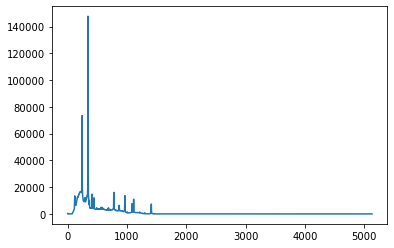

In [106]:
# Plotting Spectrum
%matplotlib inline
energy = l22['energy'].sum(1)
hist, bins = np.histogram(energy,bins=1500)
plt.plot(bins[:-1], hist)
plt.show()

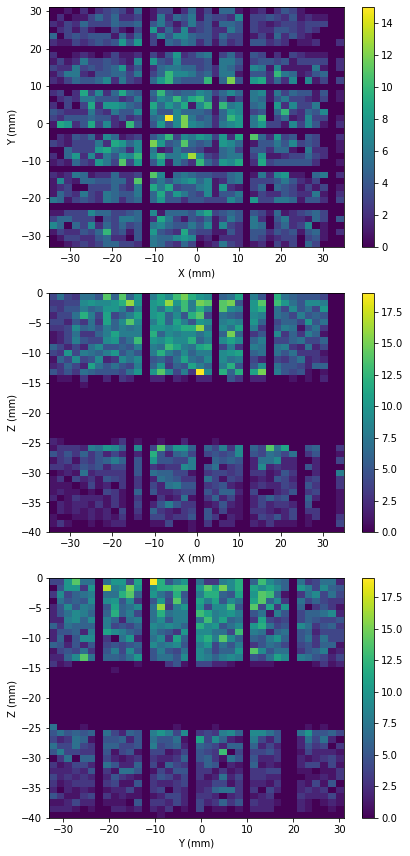

In [107]:
# Heatmap of interaction locations
%matplotlib inline
pos = interPos
plt.figure(figsize=(6,12))
# XY
plt.subplot(311)
plt.hist2d(pos[:, 0], pos[:, 1], bins=(38, 38))
plt.colorbar()
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
# XZ
plt.subplot(312)
plt.hist2d(pos[:,0], pos[:,2], bins=(38, 38))
plt.colorbar()
plt.xlabel("X (mm)")
plt.ylabel("Z (mm)")
# YZ
plt.subplot(313)
plt.hist2d(pos[:,1], pos[:,2], bins=(38, 38))
plt.colorbar()
plt.xlabel("Y (mm)")
plt.ylabel("Z (mm)")
# Render
plt.tight_layout()
plt.show()

/Users/eframe/dmi/src/compton.py:139: RuntimeWarning: invalid value encountered in sqrt
  sin_nu = np.sqrt(1 - nu**2)
/Users/eframe/dmi/src/compton.py:155: RuntimeWarning: divide by zero encountered in true_divide
  (erf((1 + mu_3) / np.sqrt(2) / Sig_3) + erf((1 - mu_3) / np.sqrt(2) / Sig_3)) / \


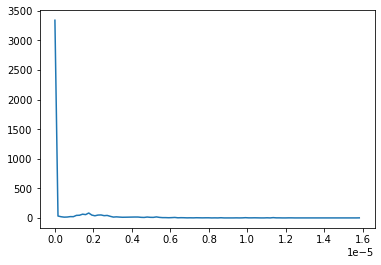

In [108]:
# Getting Backprojected Data
%matplotlib inline
backproj = compton.coneVoxel2( sourcePixelsNew, interPos, \
                        coneDir, coneMu, 0.1, 2  ) 

vals = backproj.sum(1) # summing weights of voxels for each cone
vals[ np.isnan(vals) ] = 0
hist, bins = np.histogram(vals, bins=100)
plt.plot(bins[:-1], hist)
plt.show()

In [109]:
# Getting Rid of Zero Values Events for Backprojected Data
mask = ( vals > 0.5e-6 ) 
backproj_new = backproj[mask]

In [110]:
nIter = 50
eps = 0.1
lamb = np.ones( len( sourcePixels ) )
sens = sensMap
for i in np.arange(nIter):
    print(i)
    ratio = np.zeros( len( sourcePixels ) )    
    sysMat = backproj_new
    projExpected = np.dot( sysMat, lamb )
    ratio = ratio + sysMat.T.dot(1 / projExpected)
    lamb = lamb * ratio * ( sens / ( sens ** 2 + max(sens) ** 2 * eps ** 2 ) )

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


0


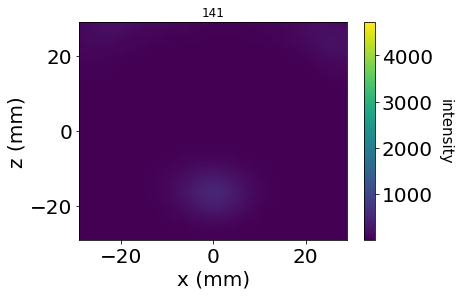

1


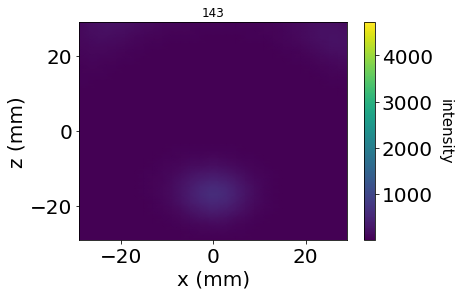

2


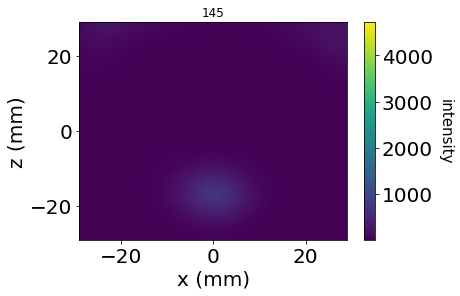

3


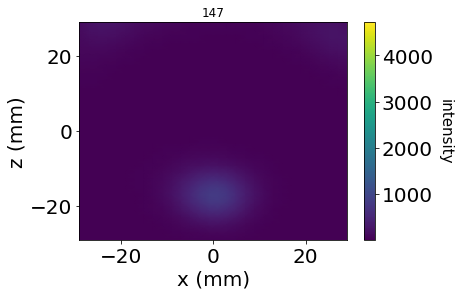

4


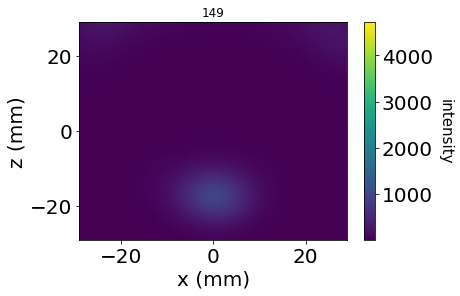

5


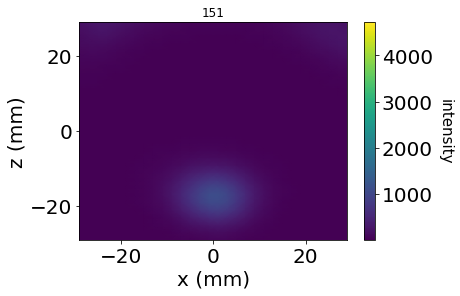

6


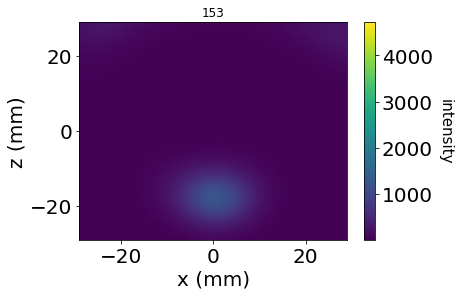

7


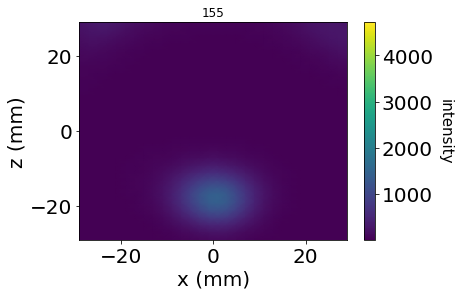

8


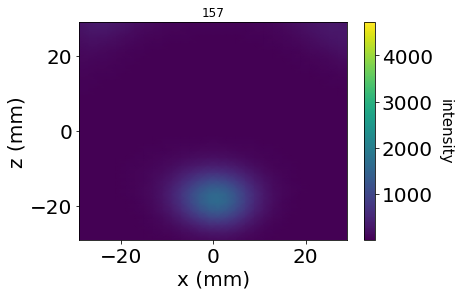

9


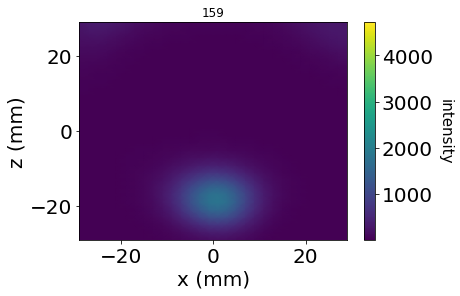

10


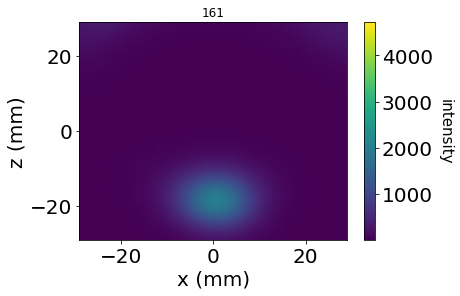

11


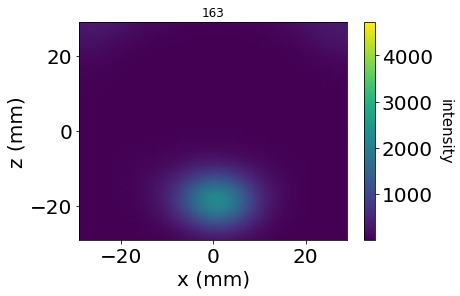

12


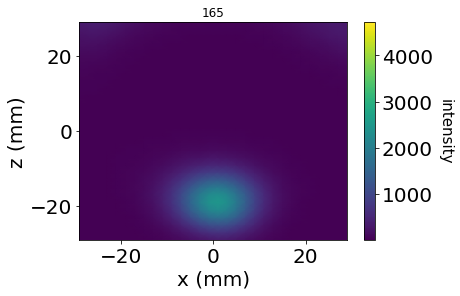

13


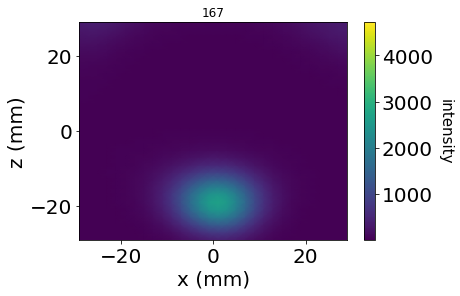

14


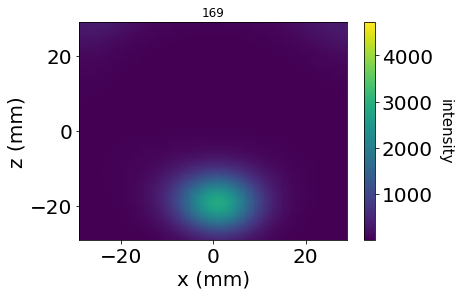

15


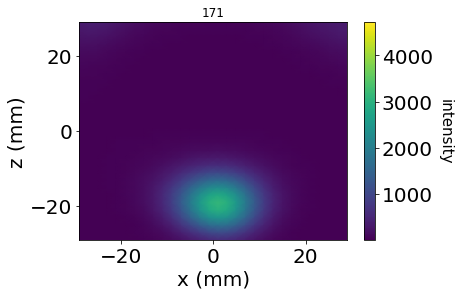

16


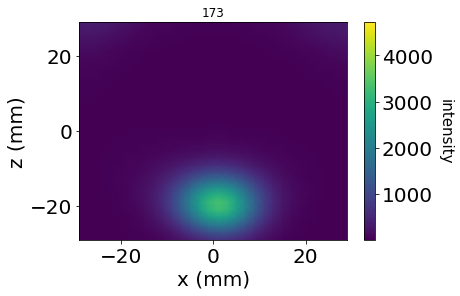

17


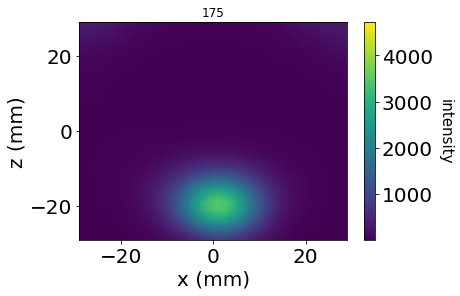

18


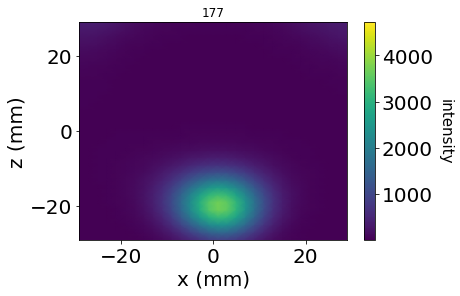

19


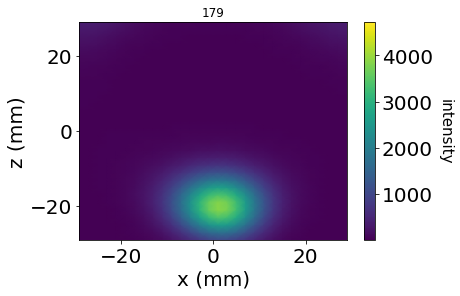

20


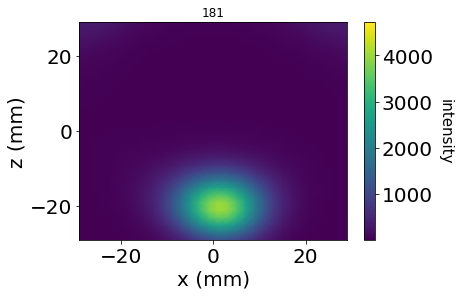

21


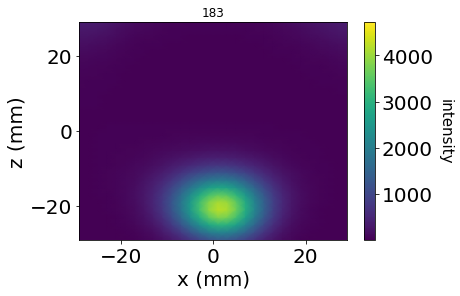

22


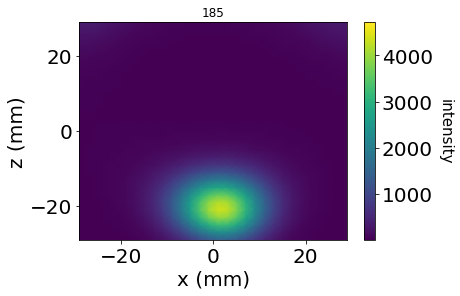

23


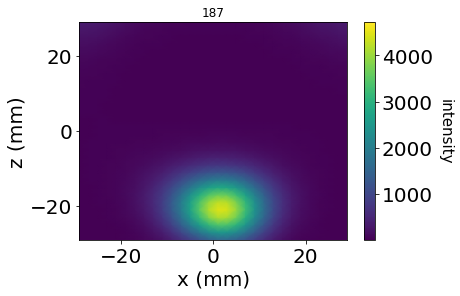

24


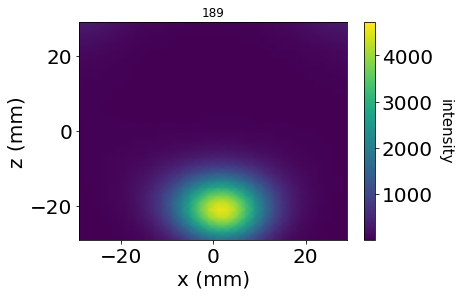

25


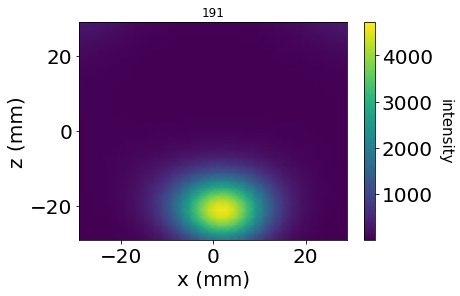

26


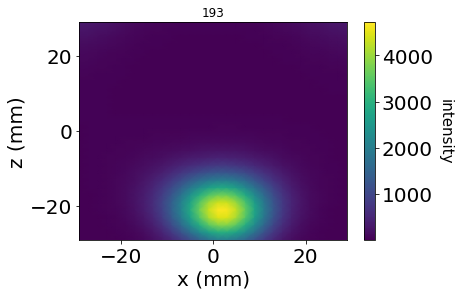

27


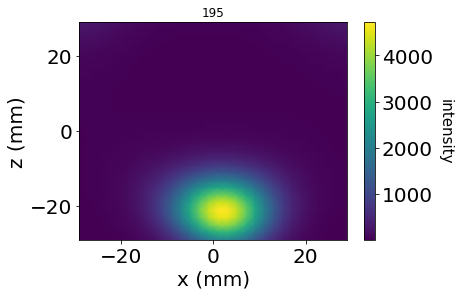

28


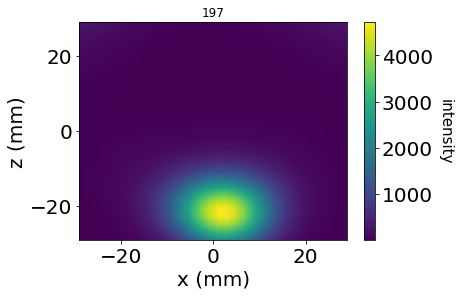

29


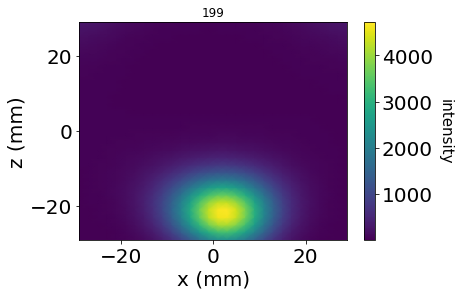

In [111]:
%matplotlib inline
depth = np.array( sourceZ[:,0][0] )[:] + C[2]
xmin, xmax = sourceX[:,0][:,0][0], sourceX[:,0][:,0][-1] + 1
ymin, ymax = sourceY[0,:][:,0][0], sourceY[0,:][:,0][-1] + 1
X, Y = np.mgrid[  xmin:xmax:2, ymin:ymax:2 ]
lamb2 = lamb.reshape(sourceX.shape)[:,:,:]
a, b = min(lamb2.flatten()), max(lamb2.flatten())
for i in np.arange( len(depth) ):
    fig, ax = plt.subplots()
    grid = lamb2[ :, :, i] 
    im = ax.pcolormesh( X, Y, grid, vmin=a, vmax=b, shading = 'gouraud' ) 
    ax.set_xlabel( 'x (mm)', fontsize = 20 )
    ax.set_ylabel( 'z (mm)', fontsize = 20 )
    ax.tick_params( labelsize = 20 )
    cbar = plt.colorbar( im )
    cbar.set_label( label = 'intensity', rotation = 270, fontsize = 15, labelpad = 20 )
    cbar.ax.tick_params( labelsize = 20 )
    plt.title( depth[i] )
    print(i)
    plt.show()

In [163]:
j = np.argmax(lamb2)
max_pixel = np.array( sourcePixelsNew[j] )
max_pixel
max_pixel = np.array([3, -21, 180])

In [19]:
# Getting Compton cones from simulated data 
E = 662
max_pixel_sim = [ 0, 0, 160 ] 
file_sim = '/Users/eframe/geant4py/output/cs137_ARM0y0z160.h5' 
f_sim = tables.open_file(file_sim, 'r')
d_sim = pd.DataFrame( f_sim.root.raw.data[:] )
f_sim.close()

# # Copy into new dataframe
data = d_sim.copy()

# Get Compton Data 
imask = ( data['interaction'] >= 0 ) & ( data['interaction'] <= 1 )
data = data[imask]

# Get Position and Energy of First Interaction
smask = data.groupby(['eventID'])['trackID'].sum().values > 1 
smask2 = data.groupby(['eventID'])['trackID'].sum().values[smask] == 2 # Doubles Events Only
emask = data.groupby(['eventID'])['E'].sum().values[smask][smask2] == E
gx1 = data.groupby(['eventID'])['gx'].first().values[smask][smask2][emask]
gy1 = data.groupby(['eventID'])['gy'].first().values[smask][smask2][emask]
gz1 = data.groupby(['eventID'])['gz'].first().values[smask][smask2][emask]
E1 = data.groupby(['eventID'])['E'].first().values[smask][smask2][emask]

# Get Position of Second Interaction
gx2 = data.groupby(['eventID']).nth(1)['gx'].values[smask2][emask]
gy2 = data.groupby(['eventID']).nth(1)['gy'].values[smask2][emask]
gz2 = data.groupby(['eventID']).nth(1)['gz'].values[smask2][emask]
E2 = data.groupby(['eventID']).nth(1)['E'].values[smask2][emask]

p1 = np.array([gx1, gy1, gz1]).T
p2 = np.array([gx2, gy2, gz2]).T

# Blurring Position Resolution
n = 2
dTheta = 0.1 # 0.1, 0.08, 0.06, 0.05, 0.04 for 2mm, 1mm, 0.5mm, 0.25mm, ideal
gx11 = np.round( gx1 / n ) * n
gy11 = np.round( gy1 / n ) * n
gz11 = np.round( gz1 / n ) * n

gx22 = np.round( gx2 / n ) * n
gy22 = np.round( gy2 / n ) * n
gz22 = np.round( gz2 / n ) * n

pos1_sim = np.array([gx11, gy11, gz11]).T
pos2_sim = np.array([gx22, gy22, gz22]).T

# Blurring Energy Resolution
energies = np.array([356, 662, 1333])
res = np.array([1.9, 2.30, 3.15]) / 2.36 # for cci-2 doubles events
fit = np.poly1d( np.polyfit(energies, res, 1) )

E1_blur, E2_blur = [], []
for i in np.arange(len(E1)):
    E1_blur.append( np.random.normal(E1[i], fit(E1[i]), 1)[0] )
    E2_blur.append( np.random.normal(E2[i], fit(E2[i]), 1)[0] )
E1_sim = np.array(E1_blur)
E2_sim = np.array(E2_blur)

In [20]:
# For Sequencing
energy = np.array( [ E1_sim, E2_sim ] ).T
pos = np.concatenate( ([ pos1_sim, pos2_sim ] ), axis = 1 ).reshape( len( pos1_sim ), 2, 3 )

# Computing Cone Data for Simulations
iP_sim, iP2_sim, cD_sim, cM_sim = convertToConeData_SIM( energy, pos, E, 14 )

# Applying Threshold to Eliminate Light-up of Corner Source Voxels
mask_sim = ( cM_sim > -0.4 ) & ( cM_sim < 1 )

iP_sim, iP2_sim, cD_sim, cM_sim = iP_sim[mask_sim], iP2_sim[mask_sim], cD_sim[mask_sim], cM_sim[mask_sim] 

/Users/eframe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


In [164]:
# Getting the angular resolution metric for each Compton cone for Detector Data
beta = []
for i in np.arange( len(interPos[mask]) ):
    vec1 = np.array( interPos[mask][i]) - np.array( max_pixel )
    vec2 = np.array( interPos2[mask][i]) - np.array( interPos[mask][i] )
    cosalpha = np.dot( vec1, vec2 ) / ( np.sqrt( np.sum( vec1 ** 2 ) ) * np.sqrt( np.sum( vec2 ** 2 ) ) )
    alpha = np.arccos( cosalpha )
    theta = np.arccos( coneMu[mask][i] )
    beta.append( theta - alpha )

In [21]:
# Getting the angular resolution metric for each Compton cone for Detector Data
beta_sim = []
for i in np.arange( len(iP_sim) ):
    vec1 = np.array( iP_sim[i]) - np.array( max_pixel_sim )
    vec2 = np.array( iP2_sim[i]) - np.array( iP_sim[i] )
    cosalpha = np.dot( vec1, vec2 ) / ( np.sqrt( np.sum( vec1 ** 2 ) ) * np.sqrt( np.sum( vec2 ** 2 ) ) )
    alpha = np.arccos( cosalpha )
    theta = np.arccos( cM_sim[i] )
    beta_sim.append( theta - alpha )

In [22]:
vec2.shape

(3,)

In [23]:
# Histogramming the angular resolution metric
hist, be = np.histogram( beta, bins=50 )
hist_sim, be_sim = np.histogram( beta_sim, bins=50 )

reset = be[:-1] * 180 / np.pi
reset_sim = be_sim[:-1] * 180 / np.pi

popt, pcov = curve_fit(lorentzian1, reset, hist/max(hist), p0 = [1, 0, 1])
popt_sim, pcov_sim = curve_fit(lorentzian1, reset_sim, hist_sim/max(hist_sim), p0 = [1, 0, 1])

vals = np.arange(min(reset), max(reset), 0.01)
lorenz_curve = lorentzian1( vals, popt[0], popt[1], popt[2] )
lorenz_curve_sim = lorentzian1( vals, popt_sim[0], popt_sim[1], popt_sim[2] )

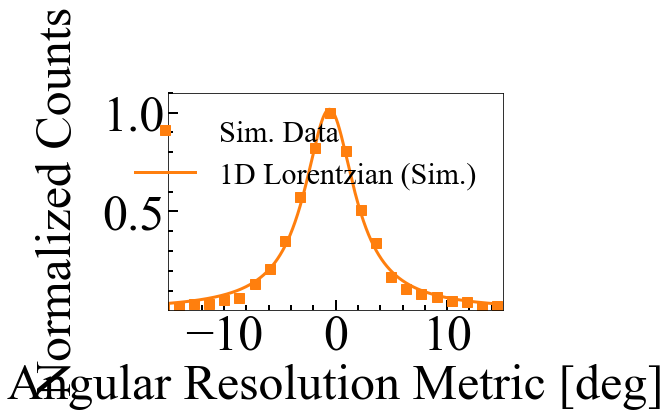

In [24]:
%matplotlib qt
font = FontProperties()
font.set_name('Times New Roman')
fig, ax = plt.subplots()
ax.set_xlabel('Angular Resolution Metric [deg]', fontsize=50, fontproperties=font)
ax.set_ylabel('Normalized Counts', fontsize=50, labelpad=20, fontproperties=font)
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=2, direction='in', labelsize=50)
ax.tick_params(which='minor', length=5, width=2, direction='in')

ax.plot( reset, hist/max(hist),'^', color='tab:blue', markersize=10, label='Exp. Data')
ax.plot(vals, lorenz_curve,'tab:blue', linewidth=3, label='1D Lorentzian (Exp.)')

ax.plot( reset_sim, hist_sim/max(hist_sim),'s', color='tab:orange', markersize=10, label='Sim. Data')
ax.plot(vals, lorenz_curve_sim,'tab:orange', linewidth=3, label='1D Lorentzian (Sim.)')

ax.legend(prop={"family":"Times New Roman", 'size': 30}, loc='upper right', frameon=False )
# ax.text(0.1, 0.9, '440 keV', transform=ax.transAxes, 
#         fontsize=40, fontproperties=font, verticalalignment='top', 
#         weight='bold', bbox=dict(facecolor='white', edgecolor='None', pad=10))
ax.set_xlim(-15, 15)
ax.set_ylim(0.00001,1.1)
# ax.grid(which='both')
for l in ax.xaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(50)
for l in ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(50)
plt.show()

In [25]:
half = np.max(lorenz_curve) / 2
half_sim = np.max(lorenz_curve_sim) / 2

mask1 = ( lorenz_curve >= half )
mask1_sim = ( lorenz_curve_sim >= half_sim )

FWHM = np.abs( vals[mask1][0] ) + np.abs( vals[mask1][-1] )
FWHM_sim = np.abs( vals[mask1_sim][0] ) + np.abs( vals[mask1_sim][-1] )

print(FWHM, FWHM_sim)

5.439999999998918


In [33]:
ang = 6.7 * np.pi / 180
2 * 55 * np.tan(ang/2)

6.4388772150032825

In [34]:
ang

0.11693705988362009

In [23]:
V = 125
r = ( V * ( 3 / 4 ) * ( 1 / np.pi ) ) ** ( 1 / 3 ) 
print( r * 2 )

6.203504908994


In [9]:
40 / 300.

0.13333333333333333

In [50]:
d = 7.83
r = d / 2
( 4 / 3 ) * ( np.pi )  * ( r ** 3 ) 

251.352904740771

In [37]:
x = ( 6*37 ) / (40+250+125)

In [41]:
x * 125

66.86746987951807

In [63]:
0.532*125

66.5

In [5]:
c = (6*37) / ( 125 + 250 + 40 )

In [19]:
40.2*c

21.504578313253013

In [10]:
249.5*c

133.46746987951806

In [11]:
125*c

66.86746987951807

In [29]:
c = (6*37)/(40.2+249.5+125)
c

0.535326742223294

In [30]:
40*0.53

21.200000000000003